In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
data = pd.read_csv("data/drug_data.csv")
labels = data["Drug"]
data.dropna(inplace=True)

print("There are " + str(len(data)) + " data samples.")

There are 200 data samples.


The basis for this project is the classification of different drugs based on the circumstances surrounding the prescription. A model for this could then be extended to choosing the proper drug for a new patient.

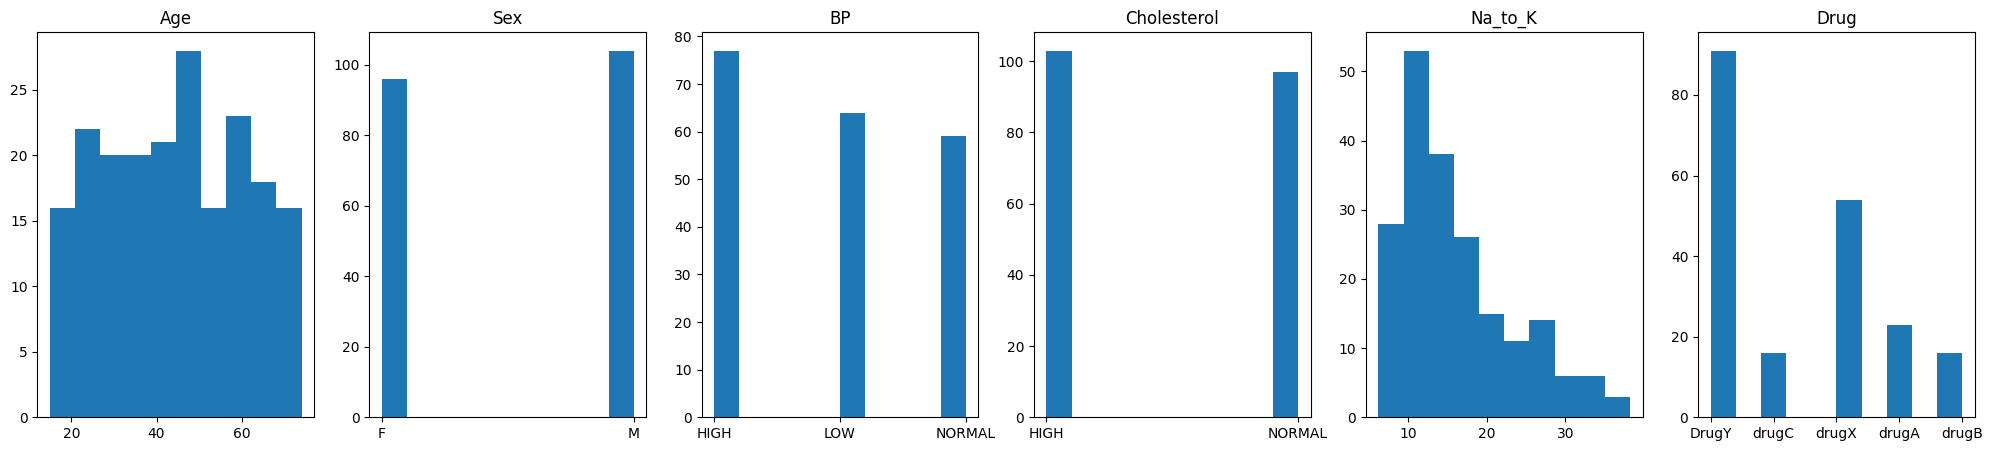

In [95]:
fig, ax = plt.subplots(1, 6, figsize=(25,5))
ax = ax.flatten()
for i, col in enumerate(data.columns):
    ax[i].set_title(col)
    ax[i].hist(data[col])

The features are all distributed relatively evenly, except the Na_to_K ratio. The "Drug" category is the category we seek to predict.

The K-Means clustering algorithm will be used for this model. Given clustering depends on a distance metric, all the data will need to be normalized. Without normalization, some features may have implicitly more importance than others. Furthermore, we also need to encode the categorical data such that they have numerical values. One-Hot encoding will be used (this essentially splits categorical variables into additional features, giving them a 1 or 0 depending on the sample). Normalization and encoding is shown below.

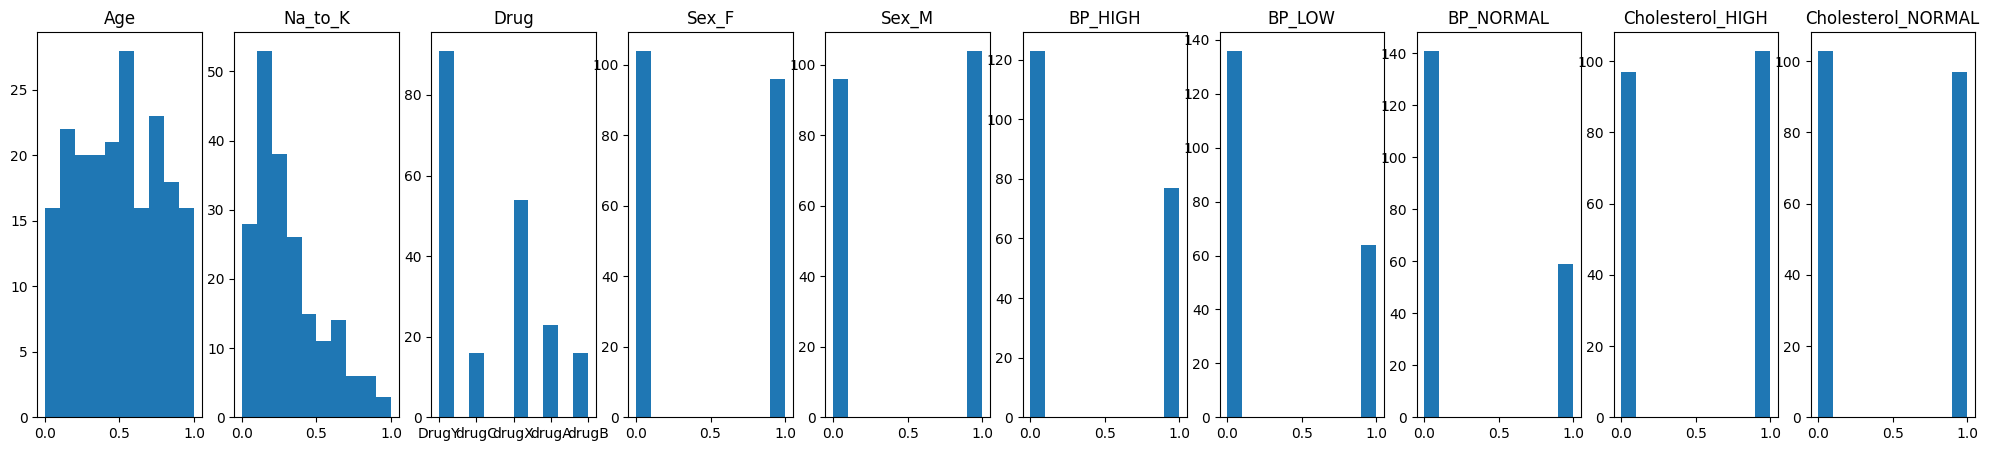

In [96]:
# Normalizing Age and Na_to_K to values between 0 and 1
data["Age"] = (data["Age"] - data["Age"].min()) / (data["Age"].max() - data["Age"].min())
data["Na_to_K"] = (data["Na_to_K"] - data["Na_to_K"].min()) / (data["Na_to_K"].max() - data["Na_to_K"].min())

# One-Hot Encoding
data = pd.get_dummies(data, columns=["Sex", "BP", "Cholesterol"], dtype='int')

# Normalized and Encoded Data
fig, ax = plt.subplots(1, 10, figsize=(25,5))
ax = ax.flatten()
for i, col in enumerate(data.columns):
    ax[i].set_title(col)
    ax[i].hist(data[col])

Now all the data is normalized and encoded such that it can be used for K-Means. The model training is next.

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import itertools

train_data = data.drop(columns=["Drug"])

def find_permutation(yt, yp):
    max_acc = 0
    max_perm = None

    yt = np.array(yt).reshape(-1)
    unique_labels = np.unique(yt)

    for perm in itertools.permutations(range(len(unique_labels))):
        label_map = {l: i for l, i in zip(unique_labels, perm)}
        labels = np.array([label_map[l] for l in yt])
        acc = accuracy_score(labels, yp)
        if acc > max_acc:
            max_acc = acc
            max_perm = {n: l for n, l in zip(perm, unique_labels)}

    return max_perm, max_acc

model_1_scores = []

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.25, shuffle=True)

    model = KMeans(n_clusters=5)
    model.fit(X_train, y_train)
    yp = model.predict(X_test)

    perm, acc = find_permutation(y_test, yp)
    model_1_scores.append(acc)

    print("Iteration " + str(i) + " Accuracy: " + str(acc))

    

Iteration 0 Accuracy: 0.46
Iteration 1 Accuracy: 0.4
Iteration 2 Accuracy: 0.32
Iteration 3 Accuracy: 0.42
Iteration 4 Accuracy: 0.46
Iteration 5 Accuracy: 0.38
Iteration 6 Accuracy: 0.4
Iteration 7 Accuracy: 0.46
Iteration 8 Accuracy: 0.44
Iteration 9 Accuracy: 0.3


As we can see, the clustering algorithm provides weak results. This necessitates trying a different unsupervised algorithm. I opt for non-negative matrix factorization next.

Iteration 0 Accuracy: 0.44
Iteration 1 Accuracy: 0.48
Iteration 2 Accuracy: 0.38
Iteration 3 Accuracy: 0.52
Iteration 4 Accuracy: 0.44
Iteration 5 Accuracy: 0.42
Iteration 6 Accuracy: 0.42
Iteration 7 Accuracy: 0.46
Iteration 8 Accuracy: 0.36
Iteration 9 Accuracy: 0.54


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(0.0, 1.0)

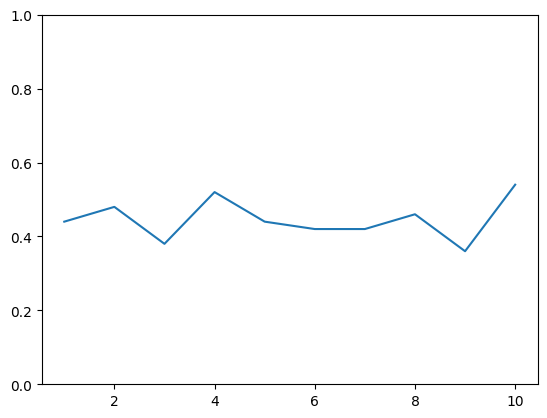

In [98]:
from sklearn.decomposition import NMF

model_2_scores= []

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.25, shuffle=True)

    model = NMF(n_components=5)
    model.fit(X_train)

    W = model.transform(X_test)
    H = model.components_
    yp = np.array([np.argmax(i) for i in W])

    perm, acc = find_permutation(y_test, yp)
    model_2_scores.append(acc)
    print("Iteration " + str(i) + " Accuracy: " + str(acc))

plt.figure()
plt.plot([i for i in range(1, 11)], model_2_scores)
plt.ylim([0, 1])



Both unsupervised models struggle with this dataset. Now we try comparing it with Ada-Boost.

In [99]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

classifier = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 150, 200], 
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

model_3_scores = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.25, shuffle=True)

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    yp = grid_search.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, yp)
    model_3_scores.append(acc)

    print("Iteration " + str(i) + " Accuracy: " + str(acc))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 0 Accuracy: 0.82
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 1 Accuracy: 0.94
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 2 Accuracy: 0.86
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 3 Accuracy: 0.84
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 4 Accuracy: 0.88
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 5 Accuracy: 0.82
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 6 Accuracy: 0.88
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 7 Accuracy: 0.86
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Iteration 8 Accuracy: 0.8
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Iteration 9 Accuracy: 0.78


C:\Users\James\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


The supervised learning model performs significantly better across runs than the unsupervised models. The results are shown below.

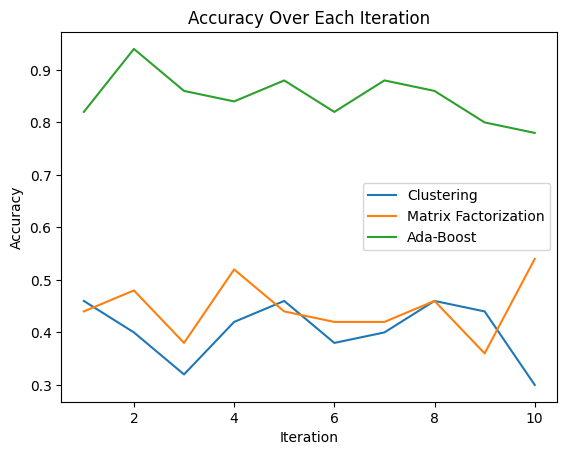

In [101]:
x = [i for i in range(1, 11)]

plt.figure()
plt.plot(x, model_1_scores, label="Clustering")
plt.plot(x, model_2_scores, label="Matrix Factorization")
plt.plot(x, model_3_scores, label="Ada-Boost")
plt.legend()
plt.title("Accuracy Over Each Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()